## Time Series Forecasting in Python

### Milestone 1 
#### Preparing the Energy and Temperture Data

In [3]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
# Using the mean_absolute_percentage_error function
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller


In [4]:
#importing the data into dataframes
#temperture data
hr_temp = pd.read_csv("hr_temp_20170201-20200131_subset.csv")
#energy data
hrl_metered = pd.read_csv("hrl_load_metered - 20170201-20200131.csv")


In [5]:
#date is done hourly; checking for any nulls in the data
#hr_temp.head()
hr_temp.isnull().sum()

STATION                      0
DATE                         0
REPORT_TYPE                  0
SOURCE                       0
HourlyDryBulbTemperature    37
dtype: int64

In [6]:
hr_temp['DATE'] = pd.to_datetime(hr_temp['DATE'],format='%Y-%m-%d %H:%M:%S')
hr_temp.dtypes

STATION                              int64
DATE                        datetime64[ns]
REPORT_TYPE                         object
SOURCE                               int64
HourlyDryBulbTemperature           float64
dtype: object

In [7]:
hr_temp.head()

,STATION,DATE,REPORT_TYPE,SOURCE,HourlyDryBulbTemperature
0,72520514762,2017-02-01 00:53:00,FM-15,7,37.0
1,72520514762,2017-02-01 01:53:00,FM-15,7,37.0
2,72520514762,2017-02-01 02:53:00,FM-15,7,36.0
3,72520514762,2017-02-01 03:53:00,FM-15,7,36.0
4,72520514762,2017-02-01 04:53:00,FM-15,7,36.0


In [8]:
#interpolation for missing values
hr_temp['HourlyDryBulbTemperature'].interpolate(inplace=True)

#Extract all the date time information for joins & et
hr_temp['hour'] = pd.DatetimeIndex(hr_temp['DATE']).hour
hr_temp['weekday'] = pd.DatetimeIndex(hr_temp['DATE']).weekday
hr_temp['month'] = pd.DatetimeIndex(hr_temp['DATE']).month
hr_temp['year'] = pd.DatetimeIndex(hr_temp['DATE']).year
hr_temp['date4join'] = pd.to_datetime(hr_temp['DATE']).dt.date

In [9]:
hr_temp.isnull().sum()

STATION                     0
DATE                        0
REPORT_TYPE                 0
SOURCE                      0
HourlyDryBulbTemperature    0
hour                        0
weekday                     0
month                       0
year                        0
date4join                   0
dtype: int64

In [10]:
#date is done hourly; checking for any nulls in the data

hrl_metered.head()

hrl_metered.isnull().sum()

datetime_beginning_utc    0
datetime_beginning_ept    0
nerc_region               0
mkt_region                0
zone                      0
load_area                 0
mw                        0
is_verified               0
dtype: int64

In [11]:
#use datetime_beginning_ept for date
hrl_metered['DATE'] = pd.to_datetime(hrl_metered['datetime_beginning_ept'],format='%m/%d/%Y %H:%M')
hrl_metered['date4join'] = pd.to_datetime(hrl_metered['DATE']).dt.date
hrl_metered['hour'] = pd.DatetimeIndex(hrl_metered['DATE']).hour
hrl_metered.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified,DATE,date4join,hour
0,2/1/2017 5:00,2/1/2017 0:00,RFC,WEST,DUQ,DUQ,1419.881,True,2017-02-01 00:00:00,2017-02-01,0
1,2/1/2017 6:00,2/1/2017 1:00,RFC,WEST,DUQ,DUQ,1379.505,True,2017-02-01 01:00:00,2017-02-01,1
2,2/1/2017 7:00,2/1/2017 2:00,RFC,WEST,DUQ,DUQ,1366.106,True,2017-02-01 02:00:00,2017-02-01,2
3,2/1/2017 8:00,2/1/2017 3:00,RFC,WEST,DUQ,DUQ,1364.453,True,2017-02-01 03:00:00,2017-02-01,3
4,2/1/2017 9:00,2/1/2017 4:00,RFC,WEST,DUQ,DUQ,1391.265,True,2017-02-01 04:00:00,2017-02-01,4


In [12]:
energy_data = hrl_metered[['date4join','hour','mw']]

In [13]:
#Create dataframe for the combined energy and temperture data 
temp_energy = hr_temp.merge(energy_data,how='left',on=['date4join','hour'])
temp_energy.rename(columns={'DATE':'date','HourlyDryBulbTemperature':'temp'},inplace=True)
temp_energy.head()

,STATION,date,REPORT_TYPE,SOURCE,temp,hour,weekday,month,year,date4join,mw
0,72520514762,2017-02-01 00:53:00,FM-15,7,37.0,0,2,2,2017,2017-02-01,1419.881
1,72520514762,2017-02-01 01:53:00,FM-15,7,37.0,1,2,2,2017,2017-02-01,1379.505
2,72520514762,2017-02-01 02:53:00,FM-15,7,36.0,2,2,2,2017,2017-02-01,1366.106
3,72520514762,2017-02-01 03:53:00,FM-15,7,36.0,3,2,2,2017,2017-02-01,1364.453
4,72520514762,2017-02-01 04:53:00,FM-15,7,36.0,4,2,2,2017,2017-02-01,1391.265


In [14]:
#checking for nulls after merging
temp_energy.isnull().sum()

STATION        0
date           0
REPORT_TYPE    0
SOURCE         0
temp           0
hour           0
weekday        0
month          0
year           0
date4join      0
mw             3
dtype: int64

In [15]:
#correcting missing values
temp_energy['mw'].interpolate(inplace=True)
temp_energy.isnull().sum()

STATION        0
date           0
REPORT_TYPE    0
SOURCE         0
temp           0
hour           0
weekday        0
month          0
year           0
date4join      0
mw             0
dtype: int64

In [16]:
#dropping extra columns and setting the date as the index
temp_energy.drop(columns=['STATION','REPORT_TYPE','SOURCE','date4join'],inplace=True)
temp_energy = temp_energy[['date','mw','temp','hour','weekday','month','year']]
temp_energy.set_index('date',inplace=True)
temp_energy.head()

,mw,temp,hour,weekday,month,year
date,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,2,2,2017
2017-02-01 01:53:00,1379.505,37.0,1,2,2,2017
2017-02-01 02:53:00,1366.106,36.0,2,2,2,2017
2017-02-01 03:53:00,1364.453,36.0,3,2,2,2017
2017-02-01 04:53:00,1391.265,36.0,4,2,2,2017


In [17]:
"""
Subsetting the data into test & train based on the following:
    - Use all of the data up through 12-31-2019 for training
    - January 2020 as your testing datasets.

Note to self:
test = temp_energy.loc[temp_energy['date'] >= '2020-01-01']  - if date is not indexed
Good references for task 4:
https://statisticsglobe.com/set-datetimeindex-pandas-dataframe-python
https://stackoverflow.com/questions/44547401/pandas-selecting-dataframe-rows-between-two-dates-datetime-index
"""

training = temp_energy[(temp_energy.index.get_level_values(0) < '2020-01-01 00:00:00')]

training.head()

,mw,temp,hour,weekday,month,year
date,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,2,2,2017
2017-02-01 01:53:00,1379.505,37.0,1,2,2,2017
2017-02-01 02:53:00,1366.106,36.0,2,2,2,2017
2017-02-01 03:53:00,1364.453,36.0,3,2,2,2017
2017-02-01 04:53:00,1391.265,36.0,4,2,2,2017


In [18]:


test = temp_energy[(temp_energy.index.get_level_values(0) >= '2020-01-01 00:00:00')]
test.head()

,mw,temp,hour,weekday,month,year
date,,,,,,
2020-01-01 00:53:00,1363.428,31.0,0,2,1,2020
2020-01-01 01:53:00,1335.975,29.0,1,2,1,2020
2020-01-01 02:53:00,1296.817,30.0,2,2,1,2020
2020-01-01 03:53:00,1288.403,30.0,3,2,1,2020
2020-01-01 04:53:00,1292.263,31.0,4,2,1,2020


### Milestone 2
#### Exploring/Visualizing Energy and Temperture Data
Objective:
Visualize the energy data you are going to model and explore the relationship between the energy data and corresponding temperature data. We will use the takeaways from these explorations to build our first model in the next section.

<Axes: xlabel='date', ylabel='Energy'>

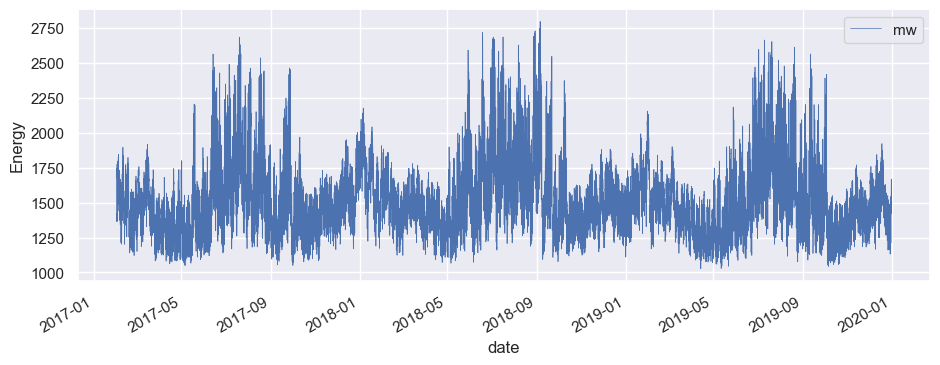

In [20]:
"""
Plotting the training energy data over time
Note to self:
Initally was going to seabourne but it had errors using the index values. Usingmatplotlib instead. See
https://github.com/mwaskom/seaborn/issues/2515
#sns.lineplot(x=training.index, y='mw',data=training)  
#This is a good tutorial as reccomended by the instructor:
https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
Using seaborn styling
The generic overall pattern from the plot below is that peak energy consumption is between June and August (summer months in). 
The lower energy usage is in the spring(April-June) and fall seasons(Sept - Nov)
"""
sns.set(rc={'figure.figsize':(11,4)})
training.plot(y='mw',ylabel= "Energy",linewidth=0.5)

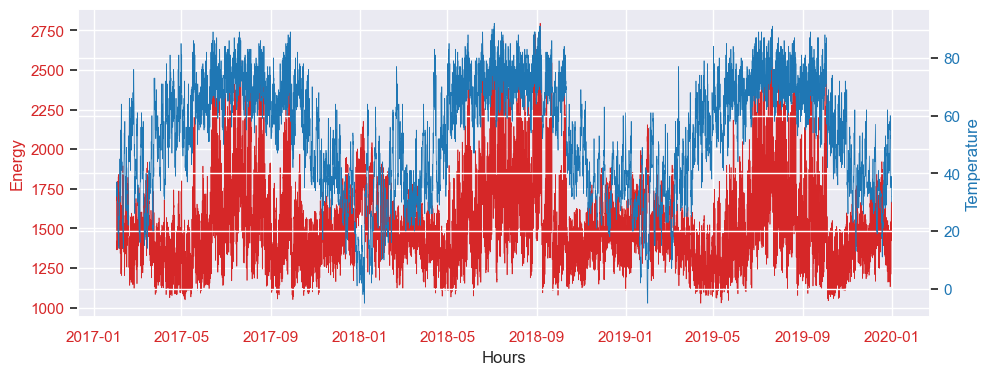

In [21]:
#Overlaying the overall energy and temperture data

fig, ax = plt.subplots()
ax2 = ax.twinx() #instantiate a second Axes that shares the same x-axis

color1 = 'tab:red'
ax.plot(training['mw'],linewidth=0.5,label='Energy',color=color1)
ax.set_xlabel('Hours')
ax.set_ylabel('Energy',color=color1)
ax.tick_params(labelcolor=color1)

color2 = 'tab:blue'
ax2.plot(training['temp'],linewidth=0.5,label='Temperature',color=color2)
ax2.set_ylabel('Temperature',color=color2)
ax2.tick_params(labelcolor=color2)

<Axes: xlabel='date', ylabel='Energy'>

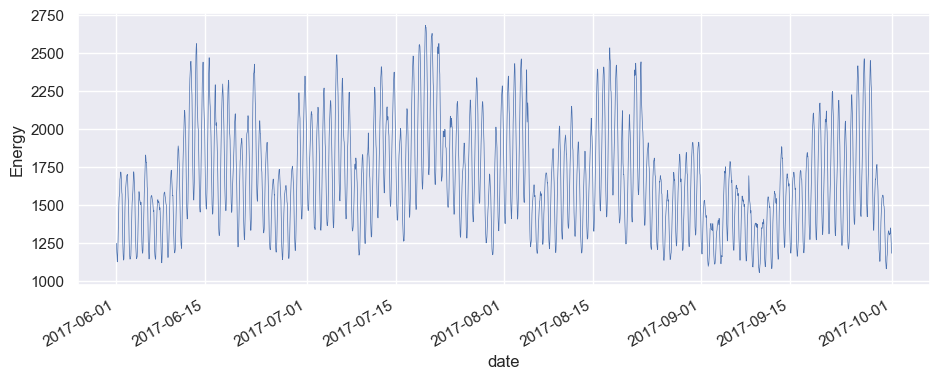

In [22]:
#Looking at months June - September
training['mw'].loc['2017-06':'2017-09'].plot(ylabel= "Energy",linewidth=0.5)

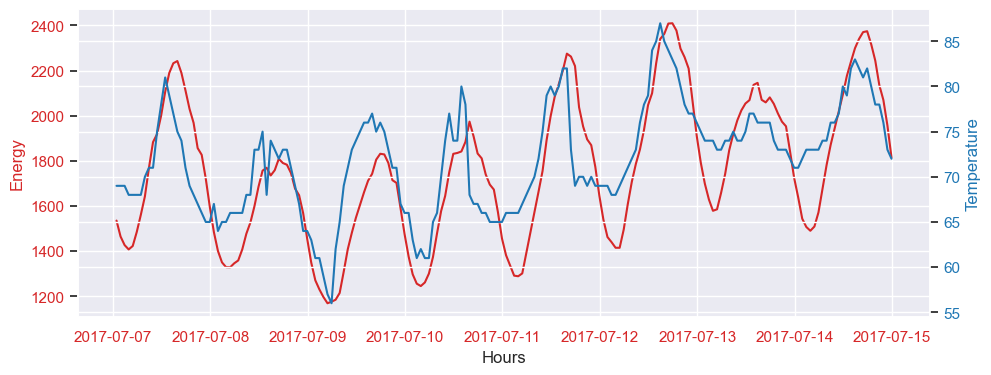

In [23]:
#Plotting one week July 7 - June 14 2017
#Overlaying energy and temperature 
#Energy and Temperture peaks appear to have a xorrelated relationship
sStart,sEnd = '2017-07-07','2017-07-14'
#training['mw'].loc['2017-07-07':'2017-07-14'].plot(linewidth=0.5,ylabel="Energy",marker='o',linestyle='-')

fig, ax = plt.subplots()
ax2 = ax.twinx() #instantiate a second Axes that shares the same x-axis

color1 = 'tab:red'
ax.plot(training.loc[sStart:sEnd,'mw'],linestyle='-',label='Energy',color=color1)
ax.set_xlabel('Hours')
ax.set_ylabel('Energy',color=color1)
ax.tick_params(labelcolor=color1)

color2 = 'tab:blue'
ax2.plot(training.loc[sStart:sEnd,'temp'],linestyle='-',label='Temperature',color=color2)
ax2.set_ylabel('Temperature',color=color2)
ax2.tick_params(labelcolor=color2)

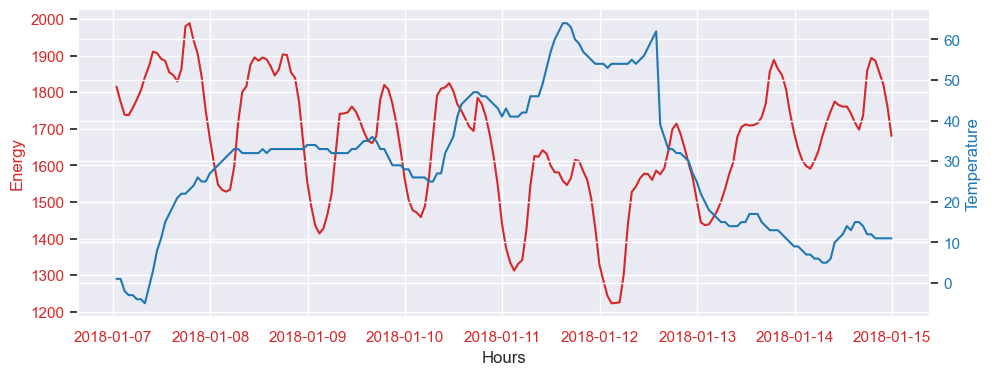

In [24]:
#Plotting one week Jan 7 - Jan 14 2017
#Overlaying energy and temperature 
#For the winter month snapshot, energy and temperture do not appear to have 
#a correlated relationship 
wStart,wEnd = '2018-01-07','2018-01-14'


fig, ax = plt.subplots()
ax2 = ax.twinx() #instantiate a second Axes that shares the same x-axis

color1 = 'tab:red'
ax.plot(training.loc[wStart:wEnd,'mw'],linestyle='-',label='Energy',color=color1)
ax.set_xlabel('Hours')
ax.set_ylabel('Energy',color=color1)
ax.tick_params(labelcolor=color1)

color2 = 'tab:blue'
ax2.plot(training.loc[wStart:wEnd,'temp'],linestyle='-',label='Temperature',color=color2)
ax2.set_ylabel('Temperature',color=color2)
ax2.tick_params(labelcolor=color2)

<Axes: xlabel='date', ylabel='Energy'>

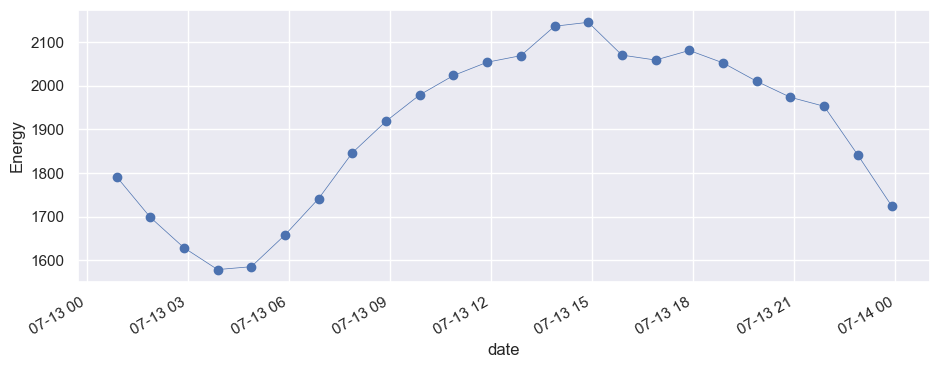

In [25]:
#Consider one day with energy only
training['mw'].loc['2017-07-13'].plot(linewidth=0.5,ylabel= "Energy",marker='o',linestyle='-')

<Axes: xlabel='date', ylabel='Temperture'>

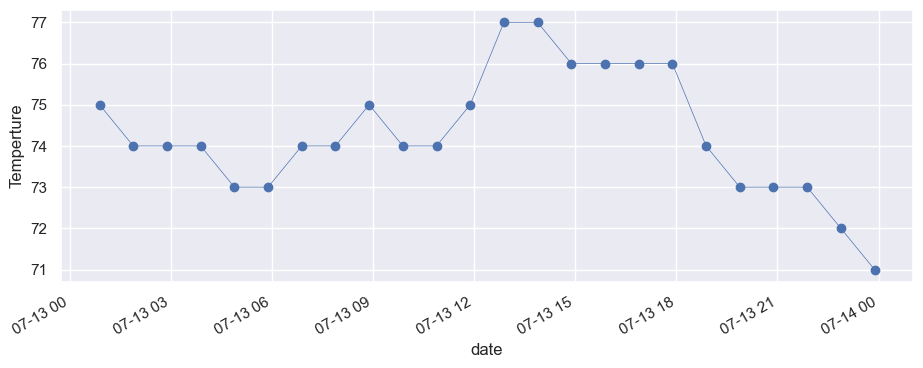

In [26]:
#Adding temp only
training['temp'].loc['2017-07-13'].plot(linewidth=0.5,ylabel="Temperture",marker='o',linestyle='-')

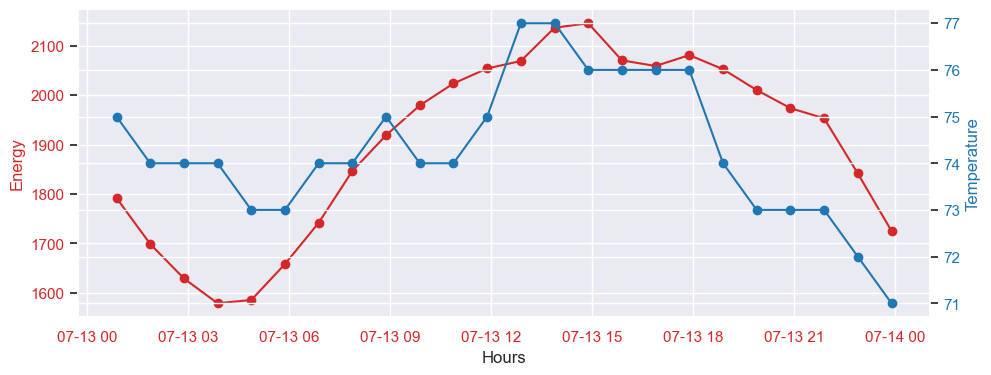

In [27]:
#tempeture and energy overlay using twinx
#One day
fig, ax = plt.subplots()
ax2 = ax.twinx() #instantiate a second Axes that shares the same x-axis

color1 = 'tab:red'
ax.plot(training.loc['2017-07-13','mw'],marker='o',linestyle='-',label='Energy(mw)',color=color1)
ax.set_xlabel('Hours')
ax.set_ylabel('Energy',color=color1)
ax.tick_params(labelcolor=color1)

color2 = 'tab:blue'
ax2.plot(training.loc['2017-07-13','temp'],marker='o',linestyle='-',label='Temperature(F)',color=color2)
ax2.set_ylabel('Temperature',color=color2)
ax2.tick_params(labelcolor=color2)
#ax.legend()


In [28]:
"""
#Calculate the correlation 
#Using Pearson
Note: Pearson (product-moment) correlation coefficient is a measure of the linear relationship between two features.
Pearson value is low (less than .5) which suggests the relationship between energy and temperture is positive and a weak correlation  

"""
pcorrelation = training['mw'].corr(training['temp'])
scorrelation = training['mw'].corr(training['temp'],method='spearman')
kcorrelation = training['mw'].corr(training['temp'],method='kendall')

print("The Pearson correlation between energy and temperture is: ",pcorrelation)
print("The Spearman rho between energy and temperture is: ",scorrelation)
print("The Kendall tau between energy and temperture is: ",kcorrelation)

The Pearson correlation between energy and temperture is:  0.3230645944433782
The Spearman rho between energy and temperture is:  0.30807462199707325
The Kendall tau between energy and temperture is:  0.2059532974957308


Text(0.5, 1.0, 'Energy and Temp Scatter')

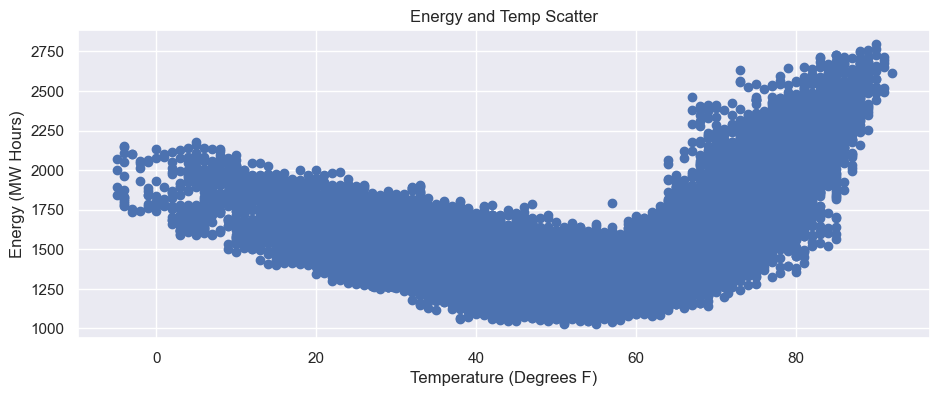

In [29]:
#Scatter Plot
plt.scatter(x='temp',y='mw',data=training)
plt.xlabel("Temperature (Degrees F)")
plt.ylabel("Energy (MW Hours)")
plt.title("Energy and Temp Scatter")

## Milestone 3
### Building the Naive Energy Model
Objective:
Linear regression models are great initial models to build that predict a continuous variable (like energy usage). The typical linear regression modeling framework uses what we call ordinary least squares (OLS) to develop the model. For more information on OLS regression feel free to click on the help section below or look further into the resources!

The foundation is laid in this step. Model building can be complicated, and sometimes it is hard to know when to stop. The best plan is to build a foundational model that you can try to build upon or outperform with later editions of your model. Without a good baseline, you won’t know how good your final model is. These seasonal effects of hours of day, days of week, and months of year, as well as the temperature effects, build a great first attempt at forecasting future energy usage.

In [31]:
"""
It is always good practice to standardize (mean of 0 and standard deviation of 1) any variable 
you are going to raise to a higher power in a regression to help prevent 
multicollinearity problems.

We will do this with the temperture.

Me: From the previous plot the shapre indicates this is not a vanilla regression but is quadratic.
This is called a z-score. See https://www.geeksforgeeks.org/how-to-standardize-data-in-a-pandas-dataframe/
"""

training['temp'] = (training['temp'] - training['temp'].mean())/training['temp'].std()
#training['tempSq'] = training['temp'].apply(lambda x: np.square(x))
new_training = training.assign(tempSq = lambda x: np.square(training['temp']))
new_training.head()

/var/folders/mw/jktxpkgn4vv70hd5fhb8f0040000gn/T/ipykernel_6002/3953586654.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['temp'] = (training['temp'] - training['temp'].mean())/training['temp'].std()


,mw,temp,hour,weekday,month,year,tempSq
date,,,,,,,
2017-02-01 00:53:00,1419.881,-0.871451,0,2,2,2017,0.759427
2017-02-01 01:53:00,1379.505,-0.871451,1,2,2,2017,0.759427
2017-02-01 02:53:00,1366.106,-0.924448,2,2,2,2017,0.854604
2017-02-01 03:53:00,1364.453,-0.924448,3,2,2,2017,0.854604
2017-02-01 04:53:00,1391.265,-0.924448,4,2,2,2017,0.854604


In [32]:
#playing around with the regression models
"""
Note: Start with a basic regression model using one variable
Not sure what the difference is but I get different results when I use OLS & OLS.from_formula
Will use OLS.from_formula for now. Keeping the other method as a comment

results = sm.OLS(new_training['mw'],new_training['temp']).fit()
print(results.summary())
"""
#Step 2
res = sm.OLS.from_formula('mw ~ temp',data= new_training).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     2976.
Date:                Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                        13:54:45   Log-Likelihood:            -1.7934e+05
No. Observations:               25539   AIC:                         3.587e+05
Df Residuals:                   25537   BIC:                         3.587e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1560.1769      1.698    918.965      0.0

In [33]:
"""
Step 2b.
Based on our knowledge including more variables as factors
# C() denotes treating variable explicitly as categorical
# Higher R squared value using the other variables but notes suggest multicolinearity
from solution
results = sm.OLS.from_formula('MW ~ Temp_Norm + Temp_Norm2 + C(weekday) + C(hour) + C(month)', data=train).fit()
"""
resF = sm.OLS.from_formula('mw ~ temp + C(hour) + C(weekday) + C(month) + tempSq',data= new_training).fit()
print(resF.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     2770.
Date:                Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                        13:54:46   Log-Likelihood:            -1.5883e+05
No. Observations:               25539   AIC:                         3.178e+05
Df Residuals:                   25496   BIC:                         3.181e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1308.2861      5.746    2

In [34]:
#print(resF.params)
print(resF.rsquared)

0.8202457055902288


Text(0.5, 1.0, 'Energy and Temp Scatter for January and July')

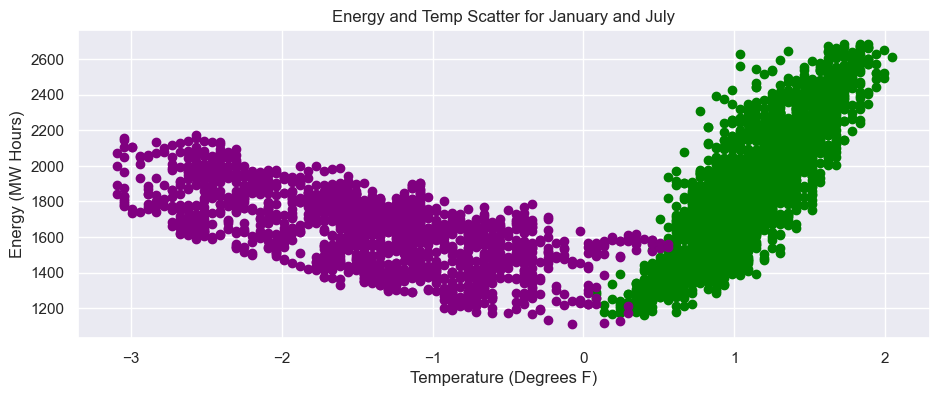

In [35]:
"""
Step 3
Plot the scatterplot between energy and temperature (as in the previous section), 
but only for the months of January and July.

The relationship between energy and temperture is different from summer and winter
Note: Asking deeper questions of the data by looking at examples of winter and summer represented data
"""

plt.scatter(x='temp',y='mw',data= new_training[new_training['month']== 7],color = 'green')
plt.scatter(x='temp',y='mw',data= new_training[new_training['month']== 1],color = 'purple')
plt.xlabel("Temperature (Degrees F)")
plt.ylabel("Energy (MW Hours)")
# Add Legend
plt.title("Energy and Temp Scatter for January and July")

Text(0.5, 1.0, 'Energy and Temp Scatter for Hours Noon and Midnight')

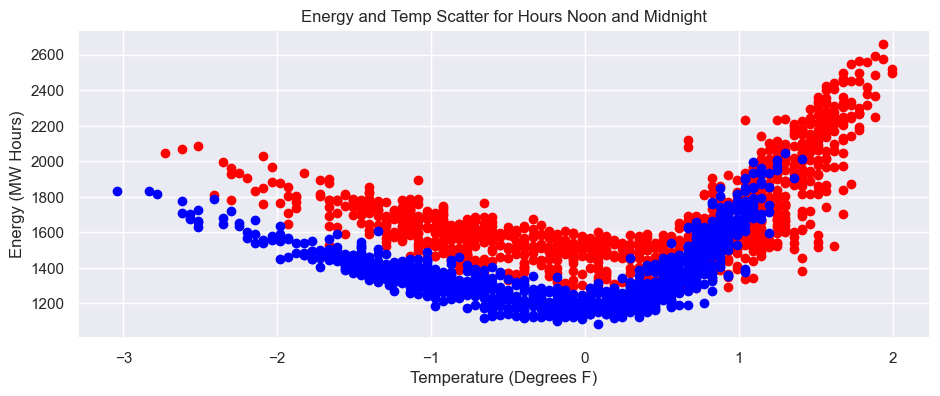

In [36]:
"""
Step 4
Plot the scatterplot between energy and temperature (as in the previous section), 
but only for the hours of midnight and noon.

Note: Even deeper look with hours included. Understanding more about the relationships will help direct the next steps to take.
"""

plt.scatter(x='temp',y='mw',data= new_training[new_training['hour']== 12],color = 'red')
plt.scatter(x='temp',y='mw',data= new_training[new_training['hour']== 0],color = 'blue')
plt.xlabel("Temperature (Degrees F)")
plt.ylabel("Energy (MW Hours)")
# Add Legend
plt.title("Energy and Temp Scatter for Hours Noon and Midnight")

In [37]:
"""
Step 5
The previous two steps reveal that energy has a different relationship with temperature depending on what time 
of day and month of year it is. These are called interactions between variables for a linear regression. Without 
those plots we might have missed that energy has a changing effect with temperature at different times. 
Add these new interactions to the linear regression model you previously built.

Interactions between variables is represented as multiplication between the two variables in a linear reression model

R-squared value is better 0.865 

from solution
results = sm.OLS.from_formula('MW ~ Temp_Norm*C(hour) + Temp_Norm2*C(hour) + Temp_Norm*C(month) + Temp_Norm2*C(month) + C(weekday)*C(hour)', 
                            data=train).fit()
"""
resF_inter = sm.OLS.from_formula('mw ~ C(hour)*temp + C(hour)*tempSq + C(month)*temp + C(month)*tempSq',data= new_training).fit()
print(resF_inter.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     1570.
Date:                Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                        13:54:47   Log-Likelihood:            -1.5515e+05
No. Observations:               25539   AIC:                         3.105e+05
Df Residuals:                   25434   BIC:                         3.114e+05
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1280.74

In [38]:
"""
Step 6
the relationship between energy and hour of day changes depending on what day of the week it is. 
Add this new interaction to your linear regression model and evaluate your model.
Adding the interaction of the day of the week to the model

Info on interactions:
https://statisticsbyjim.com/regression/interaction-effects/

New r-squared is 0.904
from solution
results = sm.OLS.from_formula('MW ~ Temp_Norm*C(hour) + Temp_Norm2*C(hour) + Temp_Norm*C(month) + Temp_Norm2*C(month) + C(weekday)*C(hour)', 
                            data=train).fit()

I had originally: 
resF_inter = sm.OLS.from_formula('mw ~ C(hour)*temp + C(hour)*tempSq + C(weekday)*temp + C(weekday)*tempSq  + C(month)*temp + C(month)*tempSq
"""

resF_inter = sm.OLS.from_formula('mw ~ C(hour)*temp + C(hour)*tempSq + C(month)*temp + C(month)*tempSq + C(weekday)*C(hour)',data= new_training).fit()
print(resF_inter.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     1085.
Date:                Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                        13:54:48   Log-Likelihood:            -1.4941e+05
No. Observations:               25539   AIC:                         2.993e+05
Df Residuals:                   25290   BIC:                         3.013e+05
Df Model:                         248                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [39]:
"""
Step 7
Calculate the predictions (or fitted values) from your final linear regression model on your training dataset. 
Calculate the MAPE(mean absolute percentage error) for these predictions from your training dataset.

Notes: creating a function using numpy. sklearn has a function that I would like to compare 
"""
def calc_mape(y_true,y_pred):
    #description: calculate the mean absolute percentage error
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    calculated_mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return np.round(calculated_mape, decimals = 3)


mw_pred = resF_inter.predict()
len(mw_pred)

25539

In [40]:
len(new_training['mw'])
my_mape = calc_mape(new_training['mw'],mw_pred)
print("MAPE for training set: ",my_mape)

MAPE for training set:  3.642


In [41]:
"""
Step 8
Run the observations through the equation we got from the training model. These are your January 2020 predictions! 
Plot your predicted energy values of your test dataset against the actual energy values. How do you like your forecast?
"""
test['temp'] = (test['temp'] - test['temp'].mean())/test['temp'].std()
new_test = test.assign(tempSq = lambda x: np.square(test['temp']))
predicted_values = resF_inter.predict(new_test)

/var/folders/mw/jktxpkgn4vv70hd5fhb8f0040000gn/T/ipykernel_6002/2783601927.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['temp'] = (test['temp'] - test['temp'].mean())/test['temp'].std()


In [42]:
print(predicted_values)

date
2020-01-01 00:53:00    1318.060653
2020-01-01 01:53:00    1301.934767
2020-01-01 02:53:00    1279.139269
2020-01-01 03:53:00    1277.467442
2020-01-01 04:53:00    1290.109112
                          ...     
2020-01-31 19:53:00    1542.361957
2020-01-31 20:53:00    1536.040754
2020-01-31 21:53:00    1494.310697
2020-01-31 22:53:00    1422.826660
2020-01-31 23:53:00    1345.737272
Length: 744, dtype: float64


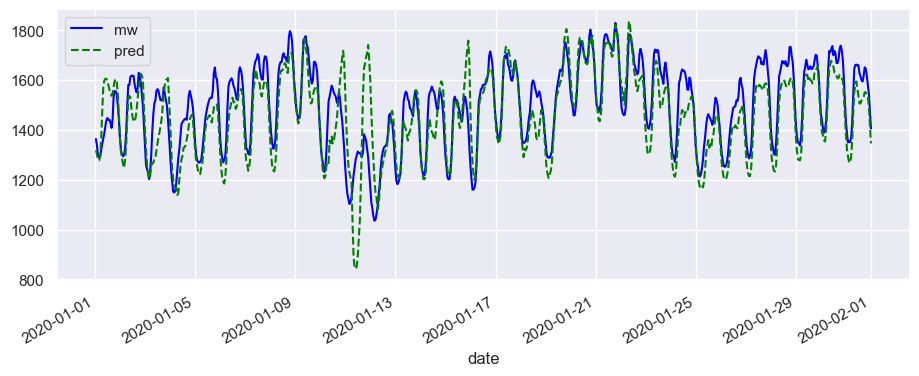

In [43]:
#working on the plot 
test.plot(y='mw',linestyle='-',color="blue")
predicted_values.plot(linestyle='--',color="green",label= "pred")
plt.legend()

## Milestone 4
## Dynamic Time Series Model
### Objective: 
Expand the linear regression model you developed in the previous section to incorporate changing effects and correlations across time. Your previous linear regression accounted for a great bit of the variation in energy usage by using different factors around time as well as temperature. However, your errors (residuals) from your linear regression model were correlated across time—making one mistake this hour affects your regression in the next hour. Time series models can help account for this.

exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data.

In [45]:
# 1) Save the residuals (errors) from the training data set
train_resid = resF_inter.resid
type(train_resid)
train_resid.head()

date
2017-02-01 00:53:00    70.135154
2017-02-01 01:53:00    64.244267
2017-02-01 02:53:00    54.746289
2017-02-01 03:53:00    54.091180
2017-02-01 04:53:00    56.399143
dtype: float64

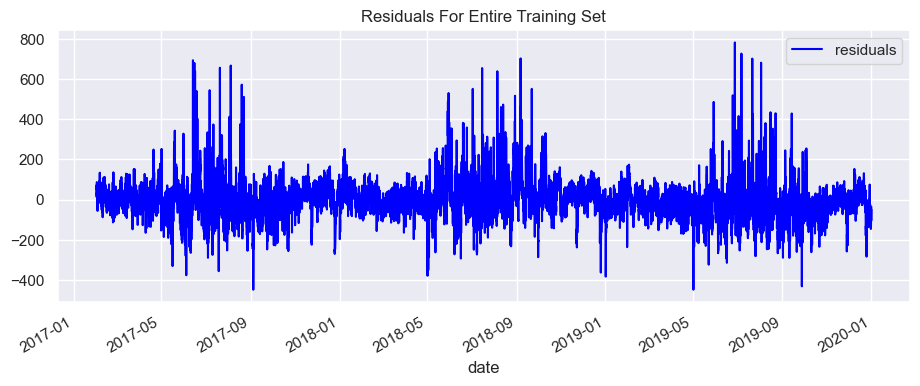

In [46]:
# 2) Visualizing the residuals
#For the entire residuals
train_resid.plot(linestyle='-',color="blue",label="residuals",title= "Residuals For Entire Training Set")
plt.legend()

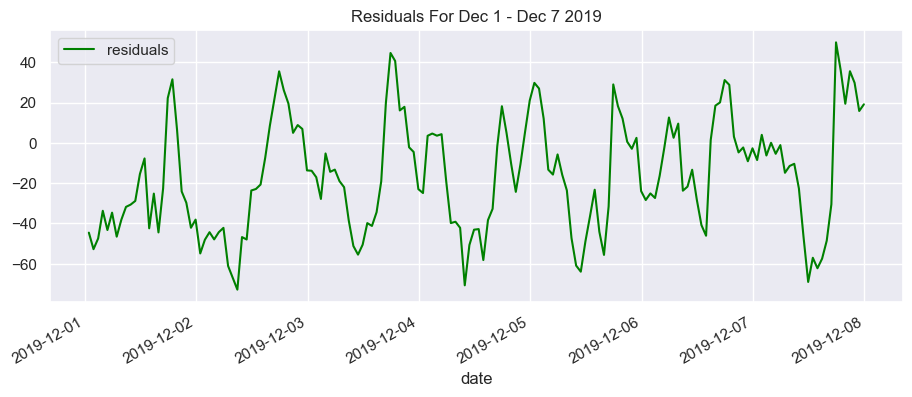

In [47]:
#For a week in Winter
rStart,rEnd = '2019-12-01','2019-12-07'
train_resid.loc[rStart:rEnd].plot(linestyle='-',color="green",label="residuals",title="Residuals For Dec 1 - Dec 7 2019")
plt.legend()

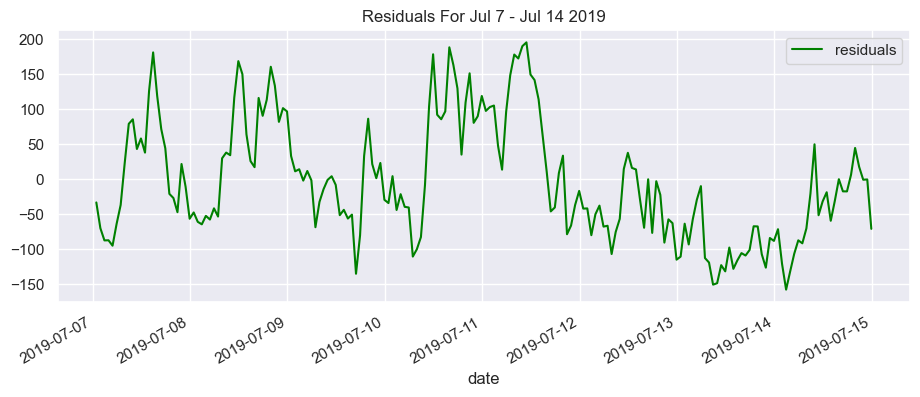

In [48]:
#For a week in Summer
rStart,rEnd = '2019-07-07','2019-07-14'
train_resid.loc[rStart:rEnd].plot(linestyle='-',color="green",label="residuals",title="Residuals For Jul 7 - Jul 14 2019")
plt.legend()

In [49]:
"""
Exponential Smoothing
We're going to build an exponential smoothing model on the residuals not incorporating trend
but does incorporate a 24-hour seasonal effect
Notes:
Good explanation of why we look at residuals:
https://allendowney.github.io/ThinkStats/chap12.html

Capturing the reading recomendations from the Live Project

- Online book Forecasting: Principals and Process
https://otexts.com/fpp3/

Forecasting using the smoothing model explanation:
https://stackoverflow.com/questions/52087404/interpolation-using-exponentialsmoothing-from-stats-models
"""
#exponential smoothing method
fitXS = ExponentialSmoothing(train_resid,initialization_method="estimated",seasonal="add",seasonal_periods=24).fit()
#print(fitXS.resid)
XS_fitval = fitXS.fittedvalues

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [50]:
fitXS.summary()

Dep. Variable:,None,No. Observations:,25539
Model:,ExponentialSmoothing,SSE,42098557.606
Optimized:,True,AIC,189233.728
Trend:,None,BIC,189445.575
Seasonal:,Additive,AICC,189233.791
Seasonal Periods:,24,Date:,"Tue, 27 May 2025"
Box-Cox:,False,Time:,13:54:52
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9918432,alpha,True
smoothing_seasonal,0.0054465,gamma,True


In [51]:
print(fitXS.fittedvalues)

date
2017-02-01 00:53:00    43.133704
2017-02-01 01:53:00    69.125653
2017-02-01 02:53:00    64.160580
2017-02-01 03:53:00    50.282062
2017-02-01 04:53:00    57.927043
                         ...    
2019-12-31 19:53:00   -80.575597
2019-12-31 20:53:00   -92.034929
2019-12-31 21:53:00   -98.777041
2019-12-31 22:53:00   -94.895145
2019-12-31 23:53:00   -71.089001
Length: 25539, dtype: float64


In [52]:
dynamic_pred = mw_pred + XS_fitval
print(dynamic_pred)

date
2017-02-01 00:53:00    1392.879550
2017-02-01 01:53:00    1384.386386
2017-02-01 02:53:00    1375.520290
2017-02-01 03:53:00    1360.643882
2017-02-01 04:53:00    1392.792900
                          ...     
2019-12-31 19:53:00    1616.020877
2019-12-31 20:53:00    1577.992767
2019-12-31 21:53:00    1518.493573
2019-12-31 22:53:00    1451.999721
2019-12-31 23:53:00    1386.040655
Length: 25539, dtype: float64


In [53]:
#Using the exponential smoothing values has improved!
mapeD = calc_mape(new_training['mw'],dynamic_pred)
print("Updated MAPE for training set using Exponetial Smoothing: ",mapeD)

Updated MAPE for training set using Exponetial Smoothing:  1.518


In [54]:

#Use the exponential smoothing model for the test data
#forecast size is the number of forecasted datapoints needed to be generated
forecast_size = 744
forecast_val = fitXS.forecast(forecast_size)

#Need to get forecast_val to have the same index as the test data
test1 = predicted_values.index.tolist()

forecast_val =forecast_val.set_axis(test1)
print(forecast_val)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


2020-01-01 00:53:00   -39.531960
2020-01-01 01:53:00   -42.332276
2020-01-01 02:53:00   -43.608834
2020-01-01 03:53:00   -44.332951
2020-01-01 04:53:00   -45.162088
                         ...    
2020-01-31 19:53:00   -48.155103
2020-01-31 20:53:00   -49.825045
2020-01-31 21:53:00   -43.637665
2020-01-31 22:53:00   -37.051560
2020-01-31 23:53:00   -35.703661
Length: 744, dtype: float64


In [55]:
#correct
dynTest_pred = predicted_values + forecast_val
print(dynTest_pred)

date
2020-01-01 00:53:00    1278.528693
2020-01-01 01:53:00    1259.602491
2020-01-01 02:53:00    1235.530435
2020-01-01 03:53:00    1233.134491
2020-01-01 04:53:00    1244.947023
                          ...     
2020-01-31 19:53:00    1494.206854
2020-01-31 20:53:00    1486.215710
2020-01-31 21:53:00    1450.673032
2020-01-31 22:53:00    1385.775100
2020-01-31 23:53:00    1310.033611
Length: 744, dtype: float64


In [135]:
"""
ARIMA modeling
SARIMAX: Seasonal AutoRegressive Integrated Moving Average with eXogenous factors. 
It extends the ARIMA model by adding seasonality and external variables.

Notes:
order:
The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. 
d must be an integer indicating the integration order of the process, 
while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) 
or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).

seasonal_order:
The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity. 
D must be an integer indicating the integration order of the process, while P and Q may either be an integers indicating 
the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include.
s is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. 
Default is no seasonal effect.

Good overview on syntax:
https://pytutorial.com/python-statsmodels-sarimax-guide-for-beginners/

Results project defaults: SARIMAX(train_resid,order=(2,0,0),seasonal_order=(0,1,1,24))
AIC: 259002.743
MAPE: 1.422

Results from: SARIMAX(train_resid,order=(2,0,0),seasonal_order=(1,1,1,24))
AIC: 258985.806
MAPE: 1.42

Results from: SARIMAX(train_resid,order=(2,0,1),seasonal_order=(0,1,1,24))
AIC: 259004.040
MAPE:1.422

"""
fitSAR = SARIMAX(train_resid,order=(2,0,0),seasonal_order=(0,1,1,24)).fit()


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.19930D+00    |proj g|=  1.06736D-01


 This problem is unconstrained.



At iterate    5    f=  5.13620D+00    |proj g|=  8.36693D-03

At iterate   10    f=  5.08306D+00    |proj g|=  5.12678D-04

At iterate   15    f=  5.07704D+00    |proj g|=  6.04509D-02
  ys=-9.672E-04  -gs= 1.995E-03 BFGS update SKIPPED

At iterate   20    f=  5.07071D+00    |proj g|=  7.01353D-03

At iterate   25    f=  5.07057D+00    |proj g|=  2.50502D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     42      1     1     0   2.505D-06   5.071D+00
  F =   5.0705733030668192     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [137]:
fitSAR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                25539
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 24)   Log Likelihood             -129497.372
Date:                              Tue, 27 May 2025   AIC                         259002.743
Time:                                      15:01:35   BIC                         259035.331
Sample:                                           0   HQIC                        259013.281
                                            - 25539                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8739      0.003    336.080      0.000       0.869       0.879
ar.L2          0.0033      0.003      1.138      0.255      -0.002       0.009
ma.S.L24      -0.9459      0.001   -635.075      0.000      -0.949      -0.943
sigma2      1496.1739      3.054    489.873      0.000    1490.188    1502.160
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1409321.52
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             2.69
Prob(H) (two-sided):                  0.21   Kurtosis:                        39.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [139]:
"""
Calculating the MAPE with ARIMA predicted residuals as to compare with Exponetential Smoothing

EXponetial Smoothing MAPE: 1.518
SARIMAX Starting Point: 1.422
"""
SAR_fitval = fitSAR.fittedvalues
dynamicSAR_pred = mw_pred + SAR_fitval

mapeS = calc_mape(new_training['mw'],dynamicSAR_pred)
print("Updated MAPE for training set using SARIMAX: ",mapeS)

Updated MAPE for training set using SARIMAX:  1.422


In [59]:
# understanding how to determine the values for SARIMAX model
# p-value < 0.05 
adResult = adfuller(train_resid)
print(f'ADF Statistic: {adResult[0]}')
print(f'p-value: {adResult[1]}')

ADF Statistic: -14.431159569789616
p-value: 7.626465707614255e-27


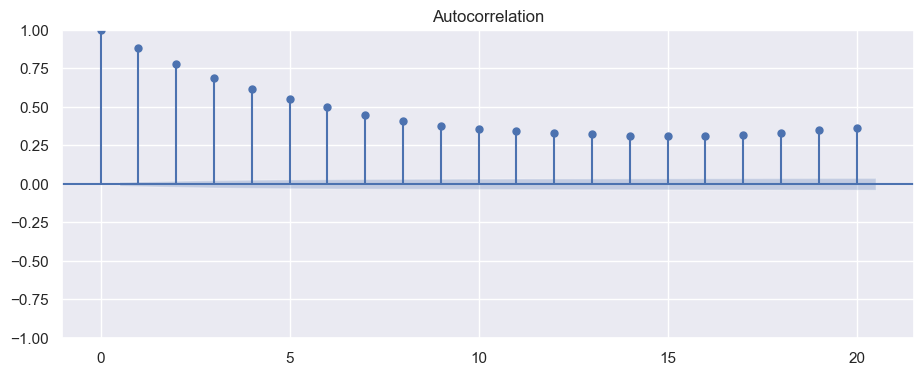

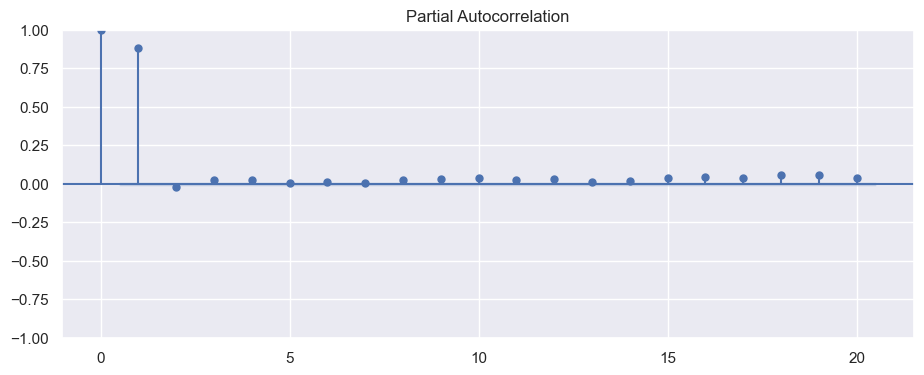

In [121]:
#plotting acf & pacf
plot_acf(train_resid,lags=20) 
plot_pacf(train_resid,lags=20)
plt.show()

In [145]:
"""
Forecasting based on the SARIMAX model
"""
#forecast size is the number of forecasted datapoints needed to be generated
# Recall the forecast size used earlierforecast_size = 744
# and test1 contains the index values from the test set
forecast_valS = fitSAR.forecast(forecast_size)

#Need to get forecast_val to have the same index as the test data
#test1 = predicted_values.index.tolist()

forecast_valS =forecast_valS.set_axis(test1)
print(forecast_valS)

2020-01-01 00:53:00   -40.865224
2020-01-01 01:53:00   -41.014899
2020-01-01 02:53:00   -36.339993
2020-01-01 03:53:00   -34.914270
2020-01-01 04:53:00   -35.426591
                         ...    
2020-01-31 19:53:00    -3.981182
2020-01-31 20:53:00   -15.370950
2020-01-31 21:53:00   -12.594577
2020-01-31 22:53:00    -2.619688
2020-01-31 23:53:00    -1.241227
Name: predicted_mean, Length: 744, dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [147]:
dynTestSAR_pred = predicted_values + forecast_valS
print(dynTestSAR_pred)

date
2020-01-01 00:53:00    1277.195430
2020-01-01 01:53:00    1260.919868
2020-01-01 02:53:00    1242.799276
2020-01-01 03:53:00    1242.553172
2020-01-01 04:53:00    1254.682520
                          ...     
2020-01-31 19:53:00    1538.380775
2020-01-31 20:53:00    1520.669804
2020-01-31 21:53:00    1481.716120
2020-01-31 22:53:00    1420.206972
2020-01-31 23:53:00    1344.496045
Length: 744, dtype: float64


In [ ]:
"""
Ensembling the two residual forecasts
"""